In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from recordtype import recordtype
from collections import defaultdict

import dadrah.util.string_constants as stco
import vande.vae.layers as layers
import dadrah.playground.qr_metric_test_model as plmo
import dadrah.playground.playground_util as pgut
import dadrah.selection.anomaly_score_strategy as ansc

setGPU: Setting GPU to: 0


# run config

In [3]:
Parameters = recordtype('Parameters','vae_run_n, qcd_train_sample_id, qcd_test_sample_id, \
                        sig_sample_id, strategy_id, read_n, quantile')
train_split = 0.3
params = Parameters(
                vae_run_n=113,
                qcd_train_sample_id='qcdSigAllTrain'+str(int(train_split*100))+'pct', 
                qcd_test_sample_id='qcdSigAllTest'+str(int((1-train_split)*100))+'pct',
                sig_sample_id='GtoWW35naReco',
                strategy_id='rk5_05',
                read_n=int(1e5),
                quantile=0.9,
                )

qr_run_n_wiggly = 222
qr_run_n_smooth = 223

# load data

In [4]:
qcd_test_sample = pgut.read_sample(params.qcd_test_sample_id, params, 'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts')

#****************************************#
#           prepare inputs & targets
#****************************************#
score_strategy = ansc.an_score_strategy_dict[params.strategy_id]
x_test, y_test = qcd_test_sample['mJJ'], score_strategy(qcd_test_sample)

2022-10-18 20:40:48 [playground_util.py:read_sample] read 100000 samples from /eos/user/k/kiwoznia/data/VAE_results/events/run_113/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_signalregion_parts/qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_70.h5


In [5]:
accuracy_bins = np.array([1199., 1255, 1320, 1387, 1457, 1529, 1604, 1681, 1761, 1844, 1930, 2019, 2111, 2206, 
                        2305, 2406, 2512, 2620, 2733, 2849, 2969, 3093, 3221, 3353, 3490, 3632, 3778, 3928]).astype('float')

# load models

In [6]:
def load(qr_run_n, params, sig_xsec=0):
    qr_model_dir = '/eos/home-k/kiwoznia/data/QR_models/vae_run_'+str(params.vae_run_n)+'/qr_run_'+str(qr_run_n)
    model_str = stco.make_qr_model_str(run_n_qr=qr_run_n, run_n_vae=params.vae_run_n, quantile=params.quantile, sig_id=params.sig_sample_id, sig_xsec=sig_xsec, strategy_id=params.strategy_id)
    path = os.path.join(qr_model_dir, model_str)
    model = tf.keras.models.load_model(path, custom_objects={'StdNormalization': layers.StdNormalization, 'QrModel': plmo.QrModel},compile=False)
    print('loaded model ', model)
    return model

def compile_for_eval(model, accuracy_bins, params):
    accuracy_bins = model.get_layer('Normalization')(accuracy_bins) # normalize inputs
    ratio_metric = plmo.binned_quantile_dev_loss(params.quantile, accuracy_bins.numpy()) #None # quantile_dev_loss(params.quantile)
    model.compile(loss=plmo.quantile_loss(params.quantile), ratio_metric=ratio_metric, optimizer=tf.keras.optimizers.Adam())
    return model

In [7]:
model_wiggly = load(qr_run_n_wiggly, params)
# compile manually because of custom loss & metrics
model_wiggly = compile_for_eval(model_wiggly, accuracy_bins, params)

loaded model  <dadrah.playground.qr_metric_test_model.QrModel object at 0x7efc2d7d2ac8>


In [8]:
model_smooth = load(qr_run_n_smooth, params)
# compile manually because of custom loss & metrics
model_smooth = compile_for_eval(model_smooth, accuracy_bins, params)

loaded model  <dadrah.playground.qr_metric_test_model.QrModel object at 0x7efc2c0e10f0>


# plot cuts

In [9]:
def plot_discriminator_cut(discriminator, sample, score_strategy, feature_key='mJJ', plot_name='discr_cut', fig_dir=None, plot_suffix=''):
    fig = plt.figure(figsize=(8, 8))
    x_min = np.min(sample[feature_key]) #norm_x.data_min_[0] #
    x_max = np.max(sample[feature_key]) #norm_x.data_max_[0] #
    an_score = score_strategy(sample)
    plt.hist2d(sample[feature_key], an_score,
           range=((x_min*0.9 , np.percentile(sample[feature_key], 1e2*(1-1e-5))), (np.min(an_score), np.percentile(an_score, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100)

    xs = np.arange(x_min, x_max, 0.001*(x_max-x_min))
    #import ipdb; ipdb.set_trace()
    plt.plot(xs, discriminator.predict([xs,xs]) , '-', color='m', lw=2.5, label='selection cut')
    plt.ylabel('L1 & L2 > LT')
    plt.xlabel('$M_{jj}$ [GeV]')
    plt.colorbar()
    plt.legend(loc='best')
    plt.show()

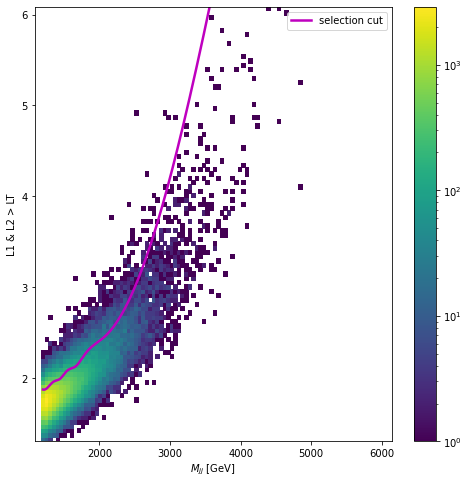

In [10]:
plot_discriminator_cut(model_wiggly, qcd_test_sample, score_strategy)

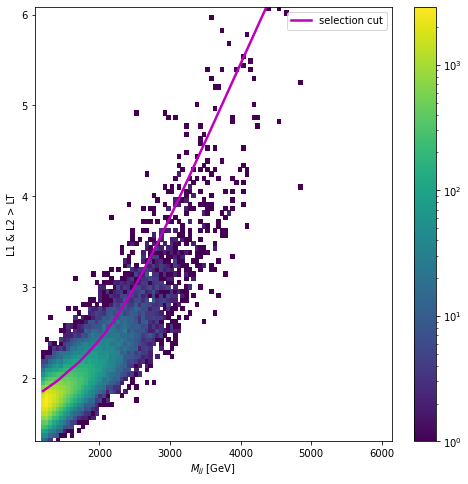

In [11]:
plot_discriminator_cut(model_smooth, qcd_test_sample, score_strategy)

# evaluate metrics

In [12]:
batch_sz=32

In [13]:
model_wiggly.evaluate(x_test,y_test,batch_size=batch_sz)

3125/3125 [==============================] - 89s 27ms/step - loss: 0.0256 - binnedQuantileDevLoss: 0.5093


[0.025552663952112198,
 0.5092549920082092,
 0.025552663952112198,
 0.5092549920082092]

In [14]:
model_smooth.evaluate(x_test,y_test,batch_size=batch_sz)

3125/3125 [==============================] - 85s 27ms/step - loss: 0.0253 - binnedQuantileDevLoss: 0.5199


[0.025295188650488853,
 0.5198765397071838,
 0.025295188650488853,
 0.5198765397071838]

In [15]:
batch_szs = [16,32,64,128,256,512,1024,2048,4096]
evals_wiggly = []
evals_smooth = []
for batch_sz in batch_szs:
    evals_wiggly.append(model_wiggly.evaluate(x_test,y_test,batch_size=batch_sz))
    evals_smooth.append(model_smooth.evaluate(x_test,y_test,batch_size=batch_sz))

25/25 [==============================] - 1s 59ms/step - loss: 0.0253 - binnedQuantileDevLoss: 0.5942


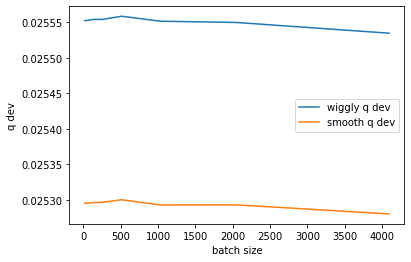

In [16]:
fig = plt.figure()
plt.plot(batch_szs,[w[2] for w in evals_wiggly],label='wiggly q dev')
plt.plot(batch_szs,[s[2] for s in evals_smooth],label='smooth q dev')
plt.legend(loc='best')
plt.xlabel('batch size')
plt.ylabel('q dev')
plt.show()

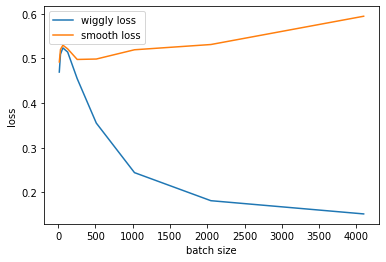

In [17]:
fig = plt.figure()
plt.plot(batch_szs,[w[1] for w in evals_wiggly],label='wiggly loss')
plt.plot(batch_szs,[s[1] for s in evals_smooth],label='smooth loss')
plt.legend(loc='best')
plt.xlabel('batch size')
plt.ylabel('loss')
plt.show()

### evaluate global deviation metric

In [18]:
y_pred_wiggly = model_wiggly.predict([x_test,y_test])
y_pred_smooth = model_smooth.predict([x_test,y_test])

In [19]:
glob_dev_fun = plmo.quantile_dev_loss(params.quantile)

In [20]:
glob_dev_fun(x_test,y_test,y_pred_wiggly).numpy()

0.6415689

In [21]:
# simulate batching
glob_metric_wiggly = []
glob_metric_smooth = []
for batch_sz in batch_szs:
    metric_wiggly_per_b_sz = 0
    metric_smooth_per_b_sz = 0
    i = 0
    while batch_sz*i < len(x_test):
        # x_test inputs needed only for batch_sz evaluation -> no need to manually normalize
        x_batch, y_batch = x_test[batch_sz*i:batch_sz*(i+1)], y_test[batch_sz*i:batch_sz*(i+1)]
        metric_wiggly_per_b_sz += glob_dev_fun(x_batch, y_batch, y_pred_wiggly[batch_sz*i:batch_sz*(i+1)]).numpy()
        metric_smooth_per_b_sz += glob_dev_fun(x_batch, y_batch, y_pred_smooth[batch_sz*i:batch_sz*(i+1)]).numpy()
        i += 1
    metric_wiggly_per_b_sz /= i
    metric_smooth_per_b_sz /= i
    glob_metric_wiggly.append(metric_wiggly_per_b_sz)
    glob_metric_smooth.append(metric_smooth_per_b_sz)

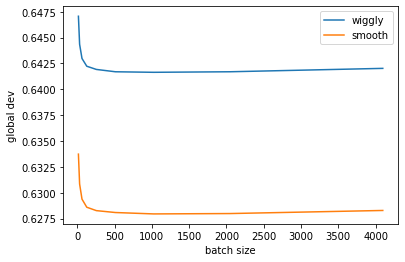

In [22]:
fig = plt.figure()
plt.plot(batch_szs,glob_metric_wiggly,label='wiggly')
plt.plot(batch_szs,glob_metric_smooth,label='smooth')
plt.legend(loc='best')
plt.xlabel('batch size')
plt.ylabel('global dev')
plt.show()

## second derivative metric

In [23]:
class scnd_deriv_metric():

    def __init__(self, delta=1e-1, name='scndDerivLoss'):
        self.name=name
        self.delta = tf.constant(delta) # delta to approximate second derivative

    # @tf.function
    def __call__(self, model, inputs, targets, predictions): # for integration in regular TF -> compute predictions for delta-shifted inputs in outside train/test step
        # import ipdb; ipdb.set_trace()
        predictions = tf.squeeze(predictions)
        pred_delta_right = tf.squeeze(model.predict([inputs+self.delta,targets])) # targets input not used in prediction
        pred_delta_left = tf.squeeze(model.predict([inputs-self.delta,targets]))
        
        # 2nd finite diff
        fini_diff2 = tf.math.divide_no_nan((pred_delta_right - 2*predictions + pred_delta_left),tf.math.square(self.delta))  

        return tf.reduce_mean(tf.math.abs(fini_diff2)) # mean per batch (-> independent of batch-size)

In [24]:
fini_diff2_fun = scnd_deriv_metric()

In [25]:
fini_diff2_fun(model_wiggly,x_test,y_test,y_pred_wiggly)

<tf.Tensor: shape=(), dtype=float32, numpy=5.858993e-05>

In [26]:
fini_diff2_fun(model_smooth,x_test,y_test,y_pred_smooth)

<tf.Tensor: shape=(), dtype=float32, numpy=4.539239e-05>

In [27]:
# simulate batching
deltas = [1e-1,5e-2,1e-2]
glob_metric_wiggly = defaultdict(list)
glob_metric_smooth = defaultdict(list)
for delta in deltas:
    fini_diff2_fun = scnd_deriv_metric(delta)
    for batch_sz in batch_szs:
        metric_wiggly_per_b_sz = 0
        metric_smooth_per_b_sz = 0
        i = 0
        while batch_sz*i < len(x_test):
            # x_test inputs needed only for batch_sz evaluation -> no need to manually normalize
            x_batch, y_batch = x_test[batch_sz*i:batch_sz*(i+1)], y_test[batch_sz*i:batch_sz*(i+1)]
            metric_wiggly_per_b_sz += fini_diff2_fun(model_wiggly, x_batch, y_batch, y_pred_wiggly[batch_sz*i:batch_sz*(i+1)]).numpy()
            metric_smooth_per_b_sz += fini_diff2_fun(model_smooth, x_batch, y_batch, y_pred_smooth[batch_sz*i:batch_sz*(i+1)]).numpy()
            i += 1
        metric_wiggly_per_b_sz /= i
        metric_smooth_per_b_sz /= i
        glob_metric_wiggly[delta].append(metric_wiggly_per_b_sz)
        glob_metric_smooth[delta].append(metric_smooth_per_b_sz)

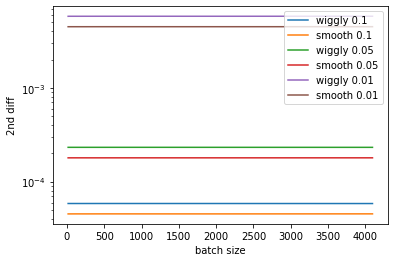

In [28]:
fig = plt.figure()
for delta in deltas:
    plt.plot(batch_szs,glob_metric_wiggly[delta],label='wiggly ' + str(delta))
    plt.plot(batch_szs,glob_metric_smooth[delta],label='smooth ' + str(delta))
plt.legend(loc='best')
plt.xlabel('batch size')
plt.ylabel('2nd diff')
plt.yscale('log')
plt.show()

In [29]:
# test 2nd derivative fun
class scnd_deriv_metric_indep():

    def __init__(self, delta=1e-1, name='scndDerivLossIndep'):
        self.name=name
        self.delta = tf.constant(delta) # delta to approximate second derivative

    # @tf.function
    def __call__(self, predictions, pred_delta_left, pred_delta_right):
        
        # 2nd finite diff
        fini_diff2 = tf.math.divide_no_nan((pred_delta_right - 2*predictions + pred_delta_left),tf.math.square(self.delta))  

        return tf.reduce_mean(tf.math.square(fini_diff2)) # mean per batch (-> independent of batch-size)

In [30]:
metric_test = scnd_deriv_metric_indep()

In [ ]:
xx = -1.0
# smooth sine
